# Decision Trees for Iris Species Classification

[Cédric Campguilhem](https://github.com/ccampguilhem), March 2018

## Table of contents

- Introduction
- Iris species dataset
- High-dimensional data visualization
- Dimensionality reduction
- What is machine learning ?
- Modelling in reduced space
- Conclusion

## Introduction

This notebook shows the capability of Decision Trees from [Scikit-Learn](http://scikit-learn.org/stable/index.html) package as well as some visualization techniques provided by [pandas](https://pandas.pydata.org/) and [seaborn](https://seaborn.pydata.org/). I have decided to use the [Iris dataset](https://www.kaggle.com/uciml/iris) to illustrate what we can do with it.

The Iris Species dataset is a famous dataset for any machine learning amateur, as it's a simple dataset which can be used for classification problems. The Iris Species dataset was originally used in R.A. Fisher's classic 1936 [paper](http://rcs.chemometrics.ru/Tutorials/classification/Fisher.pdf), The Use of Multiple Measurements in Taxonomic Problems.

I am following the Udadicty free Machine Learning [course](https://eu.udacity.com/course/machine-learning--ud262) which main problem is not to have assignments ! So this is an attempt to illustrate what I have learnt there.

## Iris species dataset

I use the Kaggle beta [API](https://github.com/Kaggle/kaggle-api) to collect the dataset on my local computer.
First we download the dataset locally. If you want to replicate this step you need to install the Kaggle beta API and create an account on Kaggle website. Finally you will need to create an API token key for your account. The GitHub [repository](https://github.com/Kaggle/kaggle-api) has all information required.

In [1]:
from kaggle.api import KaggleApi
connection = KaggleApi()
connection.authenticate()
#connection.datasetsList(search="iris")
#connection.datasetListFiles("uciml/iris")
connection.datasetDownloadFile("uciml/iris", "Iris.csv", ".")

False

We can load the dataset with pandas:

In [2]:
import pandas as pd
df = pd.read_csv("uciml/iris/Iris.csv")
df = df.set_index("Id")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [3]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
print df["Species"].value_counts(dropna=False)

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64


The dataset is pretty clean. No null values, so we will keep the 150 samples as-is. For each sample we have 4 measures:

- sepal length
- sepal width
- petal length
- petal width

For each sample we have a "class" which is the the type of iris. We have 50 samples for each type:

- setosa
- versicolor
- virginica

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)

Convert to long format to ease distribution plots:

In [7]:
df_melted = df.melt(id_vars=["Species"])
df_melted.head()

,Species,variable,value
0,Iris-setosa,SepalLengthCm,5.1
1,Iris-setosa,SepalLengthCm,4.9
2,Iris-setosa,SepalLengthCm,4.7
3,Iris-setosa,SepalLengthCm,4.6
4,Iris-setosa,SepalLengthCm,5.0


We can start be having a look a distribution for each feature:

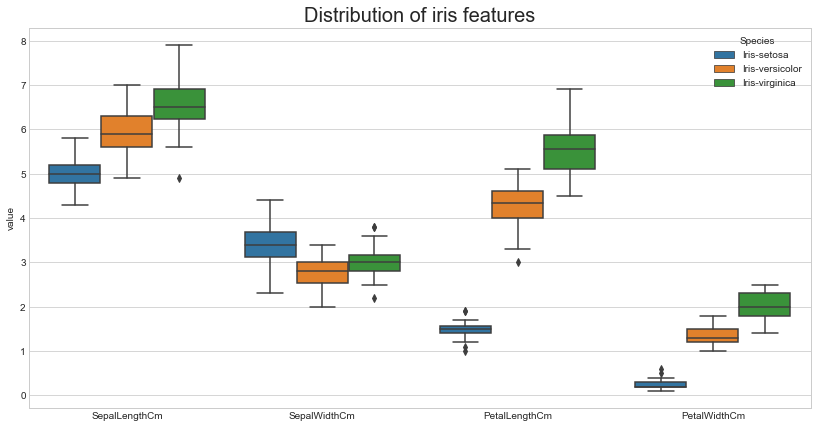

In [8]:
ax = sns.boxplot(x="variable", y="value", hue="Species", data=df_melted)
ax.set_title("Distribution of iris features", fontsize=20)
ax.set_xlabel("");

We can see that distribution for petal length and width are quite different for the 3 different species, more specifically for Iris-setosa which is smaller. Sepal features bring "less" information on how to make distinction between the species.

Another way to visualize distributions is to use histograms:

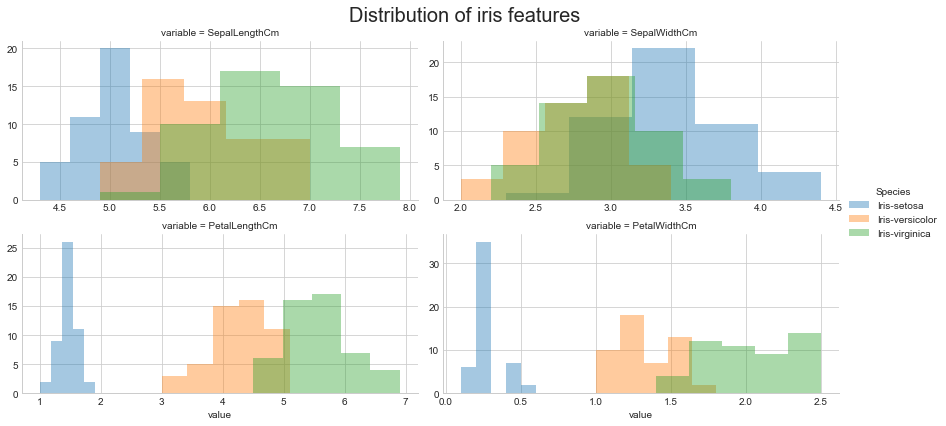

In [9]:
grid = sns.FacetGrid(df_melted, col="variable", hue="Species", col_wrap=2, sharey=False, 
                     sharex=False, aspect=2)
grid = grid.map(sns.distplot, "value", bins=5, kde=False)
grid.add_legend()
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle("Distribution of iris features", fontsize=20);

From the above plot, we confirm the difference of Iris-setosa for petal features.

We can figure out if features are correlated using a pair plot:

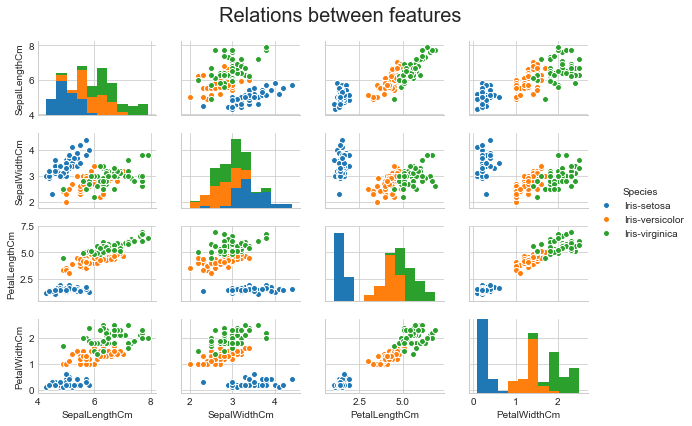

In [10]:
ax = sns.pairplot(df, hue="Species", size=1.5, aspect=1.4)
ax.fig.suptitle("Relations between features", fontsize=20)
ax.fig.subplots_adjust(top=0.9);

Sepal length is correlated (linearly) with sepal width. It is also correlated with petal length and width except for Iris-setosa. Similarly petal length and width are correlated, except for Iris-setosa.

## High-dimensional data visualization

Visualization of high-dimensional data is a challenge. Both pandas and scikit-learn bring options to the table.

The [Andrews curves](https://en.wikipedia.org/wiki/Andrews_plot) is a technique using values of features to feed a Fourier series. Each sample in the dataset is then represented by a curve:

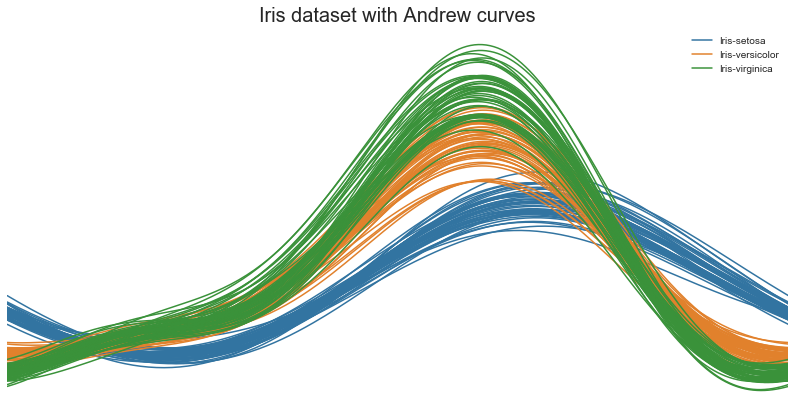

In [11]:
from pandas.plotting import andrews_curves
ax = andrews_curves(df, "Species", color=["#3274A1", "#E1812C", "#3A923A"])
ax.set_title("Iris dataset with Andrew curves", fontsize=20)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Once again, we can see that Iris-setosa clearly stands out again other species of Iris.

Another way to visualize the dataset is to used samples projection on 2D space techniques. [Scikit-learn](http://scikit-learn.org/stable/modules/manifold.html#manifold-learning) comes with manifold techniques, for example t-distributed Stochastic Neighbor Embedding (t-SNE). This method may be computationally expensive in very high-dimension spaces.

In [12]:
from sklearn.manifold import TSNE

df_features = df[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", 
                  "PetalWidthCm"]]
df_classes = df[["Species"]]

tsne = TSNE(n_components=2, random_state=1234)
df_proj = pd.DataFrame(tsne.fit_transform(df_features))
df_proj["Species"] = df_classes.Species.values
df_proj = df_proj.rename(columns={0: "var1", 1: "var2"})

In [13]:
df_proj.head()

,var1,var2,Species
0,13.301967,-21.741547,Iris-setosa
1,13.926827,-19.240252,Iris-setosa
2,12.763533,-19.004223,Iris-setosa
3,13.010967,-18.732157,Iris-setosa
4,12.847822,-21.870174,Iris-setosa


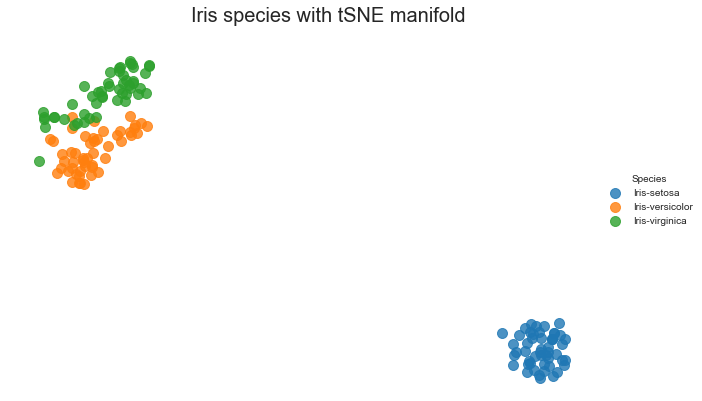

In [14]:
ax = sns.lmplot(x="var1", y="var2", hue="Species", data=df_proj, size=6, aspect=1.5, fit_reg=False, 
               scatter_kws={"s": 100})
ax.fig.suptitle("Iris species with tSNE manifold", fontsize=20)
ax.fig.subplots_adjust(top=0.9);
ax.fig.axes[0].get_xaxis().set_visible(False)
ax.fig.axes[0].get_yaxis().set_visible(False)
ax.fig.axes[0].set_frame_on(False)

For more information on t-SNE check this [video](t-SNE algorithm explained by [StatQuest](https://www.youtube.com/watch?v=NEaUSP4YerM).

## Dimensionality reduction

For such a simple problem (4 features), it is not necessary to reduce dimensionality for training an algorithm. However, it will come in handy to visualize the boundaries created by our decision tree classifier. It will be easier to visualize the boundaries of decision tree in a 2D plot, so we are going to keep only two dimensions. We will use a principal component analysis decomposition (PCA) from [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) package:

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(df_features)
df_reduced = pd.DataFrame(pca.transform(df_features))
df_reduced["Species"] = df_classes.Species.values
df_reduced = df_reduced.rename(columns={0: "var1", 1: "var2"})

In [16]:
df_reduced.head()

,var1,var2,Species
0,-2.684207,0.326607,Iris-setosa
1,-2.715391,-0.169557,Iris-setosa
2,-2.889820,-0.137346,Iris-setosa
3,-2.746437,-0.311124,Iris-setosa
4,-2.728593,0.333925,Iris-setosa


Now visualize the Iris species in a reduced data space:

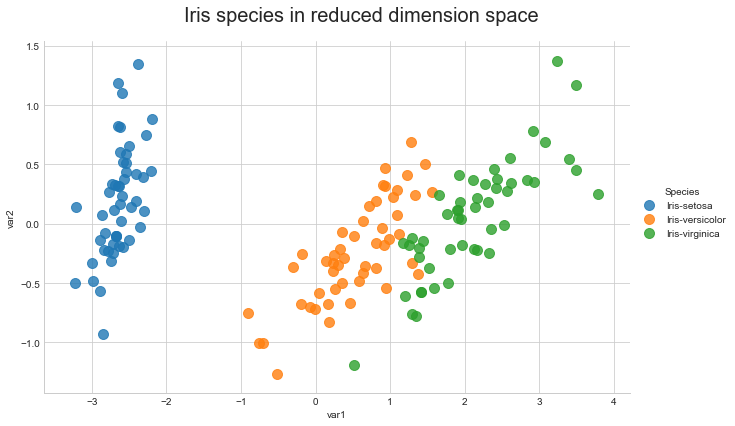

In [17]:
ax = sns.lmplot(x="var1", y="var2", hue="Species", data=df_reduced, size=6, aspect=1.5, fit_reg=False, 
               scatter_kws={"s": 100})
ax.fig.suptitle("Iris species in reduced dimension space", fontsize=20)
ax.fig.subplots_adjust(top=0.9);

We can see on this reduced dimension space that Iris-setosa is pretty easy to identify (just like in the full dimension space). The boundary between Iris-versicolor and Iris-virginica is less obvious. We will see in the next section how decision tree may be tuned to separate these three species.

## What is machine learning ?

![Machine Learning](./img/machinelearning.jpg)

Source: https://www.saagie.com/fr/blog/machine-learning-pour-les-grand-meres

### Supervised Learning:

![Machine Learning](./img/classification_vs_regression.png)

**Classification**: what is the type ?

**Regression**: what is the value ?

Source: https://medium.com/@heyozramos/regression-vs-classification-86d73c281c5e

### Our problem statement (supervised classification):

Given measures of Iris, what species is that ?

### Methodology

- Use a subset of dataset to **train** an algorithm
- Use the remaining subset to **test** algorithm

## Modelling in reduced space

In this section, we are going to train a decision tree classifier. First wee need to split the dataset into training and testing datasets. We will train the algorithm in the reduced space that we have created above with PCA.

### Split training and testing dataset

We use 30% percent of dataset for test. I am using [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) to keep the same proportion for each species in the training and testing datasets.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)
indices = splitter.split(df_features, df_classes).next()

In [19]:
features_train = df_reduced.iloc[indices[0], [0, 1]]
targets_train = df_reduced.iloc[indices[0], [2]]
features_test = df_reduced.iloc[indices[1], [0, 1]]
targets_test = df_reduced.iloc[indices[1], [2]]

In [20]:
def plot_dataset(features_train, targets_train, features_test, targets_test, clf=None, title=None):
    """
    Plot train and test datasets on given Axes
    
    - features_train: training features
    - targets_train: training classes
    - features_test: testing features
    - targets_test: testing classes
    - ax: matplotlib Axes object
    - clf: trained classifier
    """
    #Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #Classifier boundary
    if clf is not None:
        #Create a grid
        x, y = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-1.5, 1.5, 30))
        X = x.flatten()
        Y = y.flatten()
        inp = np.vstack((X, Y)).transpose()
        #Predict classes
        pred = clf.predict(inp)
        #Convert to numerical values
        dct = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
        dctinv = {0: "Iris-setosa", 1: "Iris-versicolor", 2: "Iris-virginica"}
        f = lambda x: an[x]
        conv = np.vectorize(lambda x: dct[x])
        Z = conv(pred)
        #Plot contour
        z = Z.reshape(x.shape)
        levels = [-0.5, 0.5, 1.5, 2.5]
        cf = ax.contourf(x, y, z, levels=levels, colors=["#3274A1", "#E1812C", "#3A923A"], alpha=0.5)
        cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", aspect=20, fraction=0.07, shrink=1)
        cbar.set_ticks([0,1,2])
        cbar.set_ticklabels([dctinv[t] for t in [0,1,2]])
    #Display dataset
    for (species, color) in [("Iris-setosa", "#3274A1"), ("Iris-versicolor", "#E1812C"), ("Iris-virginica", "#3A923A")]:
        train = features_train[targets_train.Species == species]
        test = features_test[targets_test.Species == species]
        label_train = "{} ({})".format(species, "Train")
        label_test = "{} ({})".format(species, "Test")
        ax.scatter(x=train["var1"], y=train["var2"], color=color, marker="o", s=200, label=label_train, 
                   edgecolors="#ffffff")
        ax.scatter(x=test["var1"], y=test["var2"], color=color, marker="^", s=200, label=label_test, 
                  edgecolors="#ffffff")
    #Plot configuration
    if title is None:
        ax.set_title("Train and test dataset", fontsize=20)
    else:
        ax.set_title(title, fontsize=20)
    ax.set_xlabel("var1")
    ax.set_ylabel("var2")
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=True);    
    return ax

Let's visualize the split that has been operated:

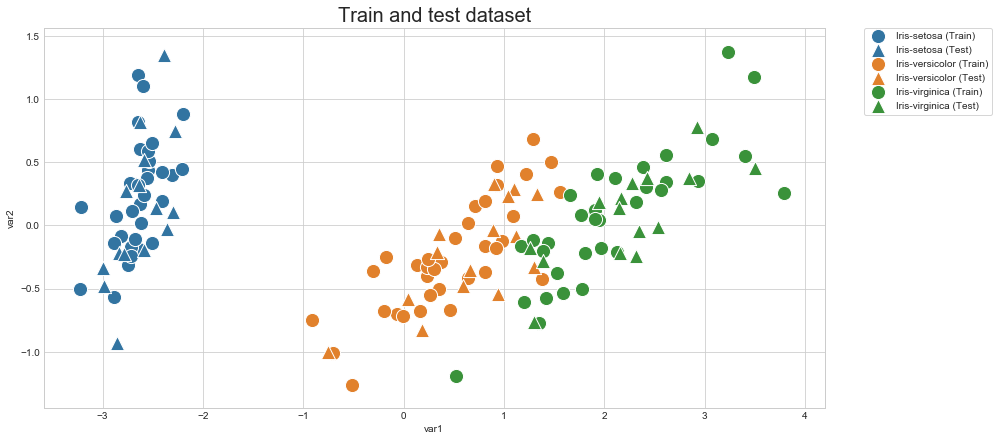

In [21]:
plot_dataset(features_train, targets_train, features_test, targets_test);

We can see that for each species, test samples have been randomized to cover the space occupied by that species.

### Train a decision tree

We are going to make the following assumption: the dataset is linearly separable. We then restrict the algorithm to only draws a very simple boundary. We can achieve this by limiting the maximum depth of decision tree to 1:

In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1234, max_depth=1)
clf.fit(features_train, targets_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

A linear boundary (background color) is calculated by the algorithm, which enables to identify Iris-setosa but not the other species:

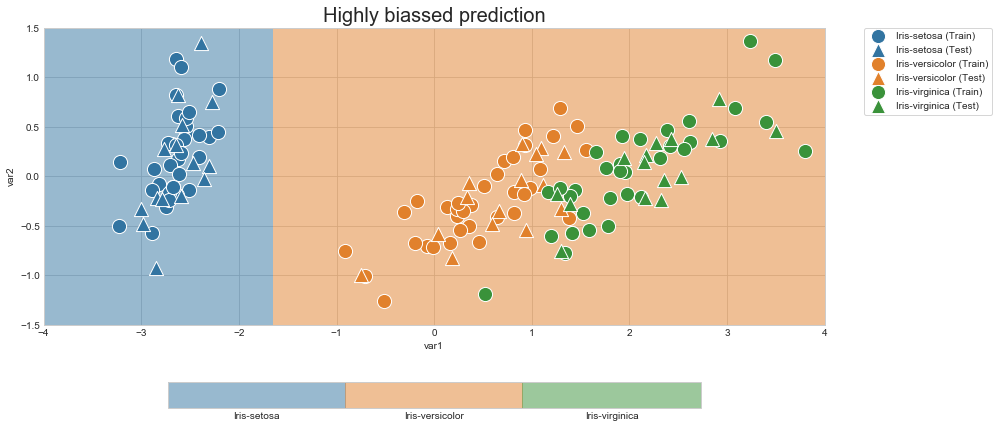

In [23]:
plot_dataset(features_train, targets_train, features_test, targets_test, clf, title="Highly biassed prediction");

Now reduce the bias by increasing the maximum depth of decision tree to 2. The algorithms does a better job but may still be improved:

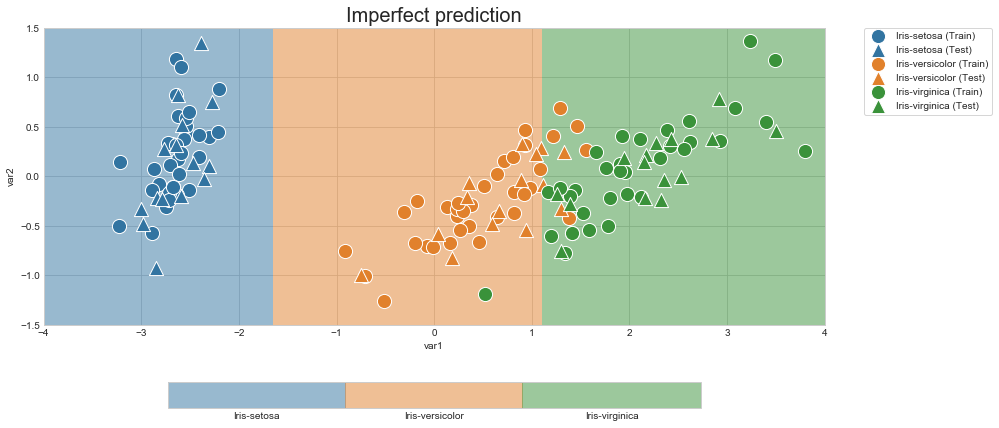

In [24]:
clf = DecisionTreeClassifier(random_state=1234, max_depth=2)
clf.fit(features_train, targets_train)
plot_dataset(features_train, targets_train, features_test, targets_test, clf, title="Imperfect prediction");

Increasing the maximum depth to 4 shows very interesting results even if few samples are incorrectly predicted:

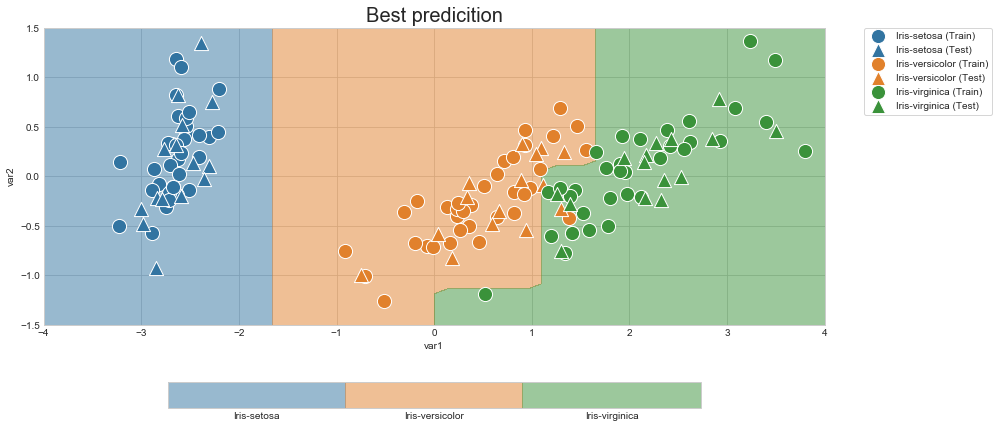

In [25]:
clf = DecisionTreeClassifier(random_state=1234, max_depth=4)
clf.fit(features_train, targets_train)
plot_dataset(features_train, targets_train, features_test, targets_test, clf, title="Best predicition");

In [26]:
#Export the decision to Graphviz format
from sklearn.tree import export_graphviz
export_graphviz(clf, "tree.dot", rounded=True, impurity=False, 
                feature_names=["var1", "var2"], class_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])

In [27]:
!dot -Tpng tree.dot -o img/tree.png

Increasing the maximum depth to 6 shows that decision tree tries to get the previously incorrectly predicted samples. This increases the variance of the model, it becomes very sensible to "exceptional" values. This is a situation of over-fitting that should be avoided:

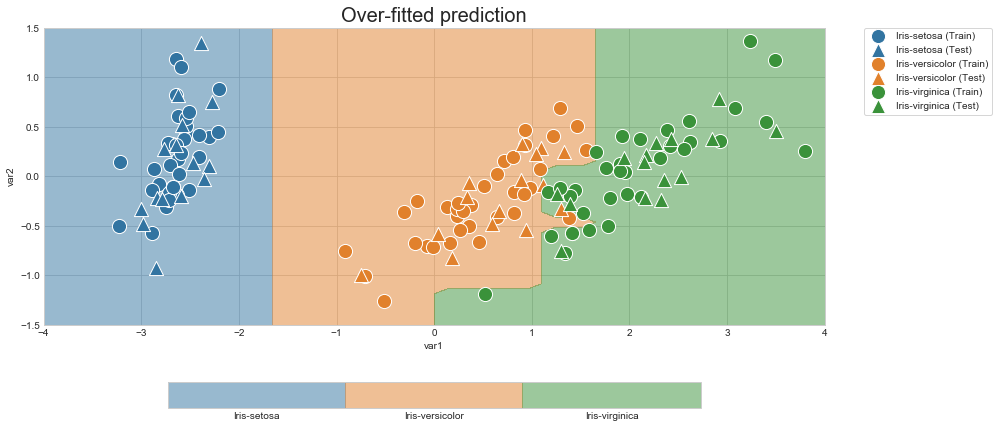

In [28]:
clf = DecisionTreeClassifier(random_state=1234, max_depth=6)
clf.fit(features_train, targets_train)
plot_dataset(features_train, targets_train, features_test, targets_test, clf, title="Over-fitted prediction");

A decision tree with a maximum depth of 4 is probably the best trade-off between:

- **bias**: errors from initial assumptions in algorithm
- **variance**: errors due to sensitivity to small fluctuations in training dataset

A good predictive model has low bias and low variance.

Here is our decision trained tree:

<img src="./img/tree.png" alt="Tree" style="width: 600px;"/>

Another way to measure accuracy of a predictive model is to use metrics:

In [29]:
from sklearn.metrics import precision_recall_fscore_support

clf = DecisionTreeClassifier(random_state=1234, max_depth=4)
clf.fit(features_train, targets_train)
targets_pred = clf.predict(features_test)

precision, recall, fscore, support = precision_recall_fscore_support(
    targets_test, targets_pred)
df_metrics = pd.DataFrame({"precision": precision, 
                           "recall": recall, 
                           "fscore": fscore, 
                           "Species": ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]})
df_metrics.set_index("Species", inplace=True)

- **precision**: prediction is consistent with the actual class of test sample
- **recall**: capability to correctly predict all items of a given class
- **fscore**: averaged score between precision and recall

In [30]:
df_metrics.head()

,fscore,precision,recall
Species,,,
Iris-setosa,1.000000,1.0000,1.000000
Iris-versicolor,0.965517,1.0000,0.933333
Iris-virginica,0.967742,0.9375,1.000000


Here, we have one Iris-versicolor which has been predicted as a Iris-virginica. This decreases the **precision** of Iris-virginica and the **recall** of Iris-versicolor.

## Conclusion

- pandas and seaborn provides usefull and easy-to-use capabilities to **see** the data, even in high-dimension.
- Tempted by marchine learning ? Start with **decision trees** and avoid complex alternatives (neural networks...).
- **Always** keep samples to test accurary of your predictive model.
- Consider **dimension reduction** to better understand the behavior of your predictive model.
- Tune parameters to reach a **low-bias** and a **low-variance** model.
- Someone claims he has incredible predictive model ? Ask he/she the **precision** and the **recall** scores on the **test** samples, just in case...

## Appendix

t-SNE algorithm explained by [StatQuest](https://www.youtube.com/watch?v=NEaUSP4YerM)<hr>

In [33]:
#Convert notebook to html
!jupyter nbconvert --to html --template html_minimal.tpl iris_dataset_classification.ipynb

[NbConvertApp] Converting notebook iris_dataset_classification.ipynb to html
[NbConvertApp] Writing 1220043 bytes to iris_dataset_classification.html


In [34]:
#Convert notebook to slide show
!jupyter nbconvert --to slides iris_dataset_classification.ipynb

[NbConvertApp] Converting notebook iris_dataset_classification.ipynb to slides
[NbConvertApp] Writing 1201343 bytes to iris_dataset_classification.slides.html
